In [142]:
import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc

print "Verzije"
print "Numpy - %12s" % np.__version__
print "Scipy - %12s" % scipy.__version__
print "Tensorflow - %7s" % tf.__version__
print "Matplotlib - %7s" % matplotlib.__version__

Verzije
Numpy -       1.12.0
Scipy -       0.18.1
Tensorflow -  0.12.1
Matplotlib -   2.0.0


# Original model bez fully connected layera
http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.svg

In [143]:
import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy.misc


def get_img(src, img_size=False):
    img = scipy.misc.imread(src, mode='RGB') # misc.imresize(, (224, 224, 3))
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        img = np.dstack((img,img,img))
    if img_size != False:
        img = scipy.misc.imresize(img, img_size)
    return img

MEAN_PIXEL = np.array([ 123.68 ,  116.779,  103.939])

def net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4',
        
        'pool5'
    )

    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]

    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current

    assert len(net) == len(layers)
    return net


def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)


def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

def preprocess(image):
    return image - MEAN_PIXEL


def unprocess(image):
    return image + MEAN_PIXEL

(1, 224, 224, 3)


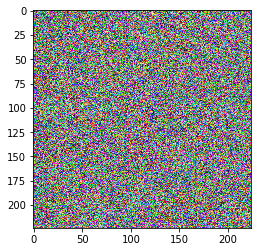

In [144]:
random_matrix = np.random.rand(1,224,224,3)
print random_matrix.shape
plt.imshow(random_matrix[0])
plt.show()

In [145]:
tf.reset_default_graph()
with tf.Graph().as_default(), tf.device('/cpu:0'), tf.Session() as sess:
    VGG_PATH = '/home/user/fast-neural/imagenet-vgg-verydeep-19.mat'
    plac = tf.placeholder(tf.float32, [None,None,None,None])
    plac_preprocess = preprocess(plac)
    vgg = net(VGG_PATH, plac_preprocess)
    res = vgg['pool5'].eval(feed_dict={plac_preprocess:random_matrix})
#vgg

In [146]:
print 7*7*512
res.shape

25088


(1, 7, 7, 512)

# Moje igranje da vidim kako je zapisan ostatak podataka iz .mat formata, zanemarite ovo dole

In [147]:
layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4',
        
        'pool5'
    )
len(layers)

37

In [148]:
data = scipy.io.loadmat(VGG_PATH)

In [149]:
print data['layers'][0][37][0][0][0][0][0].shape #npr ovo bi bio fc6 layer weights
print data['layers'][0][37][0][0][0][0][1].shape #npr ovo bi bio fc6 layer bias

(7, 7, 512, 4096)
(1, 4096)
